# Explore pyiron-like workflows

Aim: Explore how close the presently available features of the pyiron_workflow class allow us to write pyiron-like workflows

In [1]:
%config IPCompleter.evaluation='unsafe'

import matplotlib.pylab as plt
import numpy as np
from pyiron_workflow.workflow import Workflow

In [2]:
%%time
# from pyiron_atomistics.atomistics.structure.atoms import Atoms

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [3]:
import warnings
warnings.filterwarnings('ignore')

### Create structure and list available potentials

In [4]:
wf = Workflow('Lammps')
wf.register('atomistic', 'pyiron_workflow.node_library.atomistic')
wf.register('atomistic_codes', 'pyiron_workflow.node_library.atomistic_codes')

In [5]:
wf = Workflow('Lammps')
wf.structure = wf.create.atomistic.structure.build.bulk('Al', cubic=True)
wf.repeat = wf.create.atomistic.structure.transform.repeat(structure = wf.structure, repeat_scalar=1)

wf.lammps = wf.create.atomistic_codes.Lammps(structure=wf.repeat, label='lammps')
wf.lammps.ListPotentials()[:5]

['1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1',
 '1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1',
 '1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1']

In [6]:
wf = Workflow('Lammps')
wf.structure = wf.create.atomistic.structure.build.bulk('Al', cubic=True)
wf.repeat = wf.create.atomistic.structure.transform.repeat(structure = wf.structure, repeat_scalar=1)

wf.lammps = wf.create.atomistic_codes.Lammps(structure=wf.repeat, label='lammps')
wf.lammps.ListPotentials()[:5]

['1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1',
 '1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1',
 '1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1']

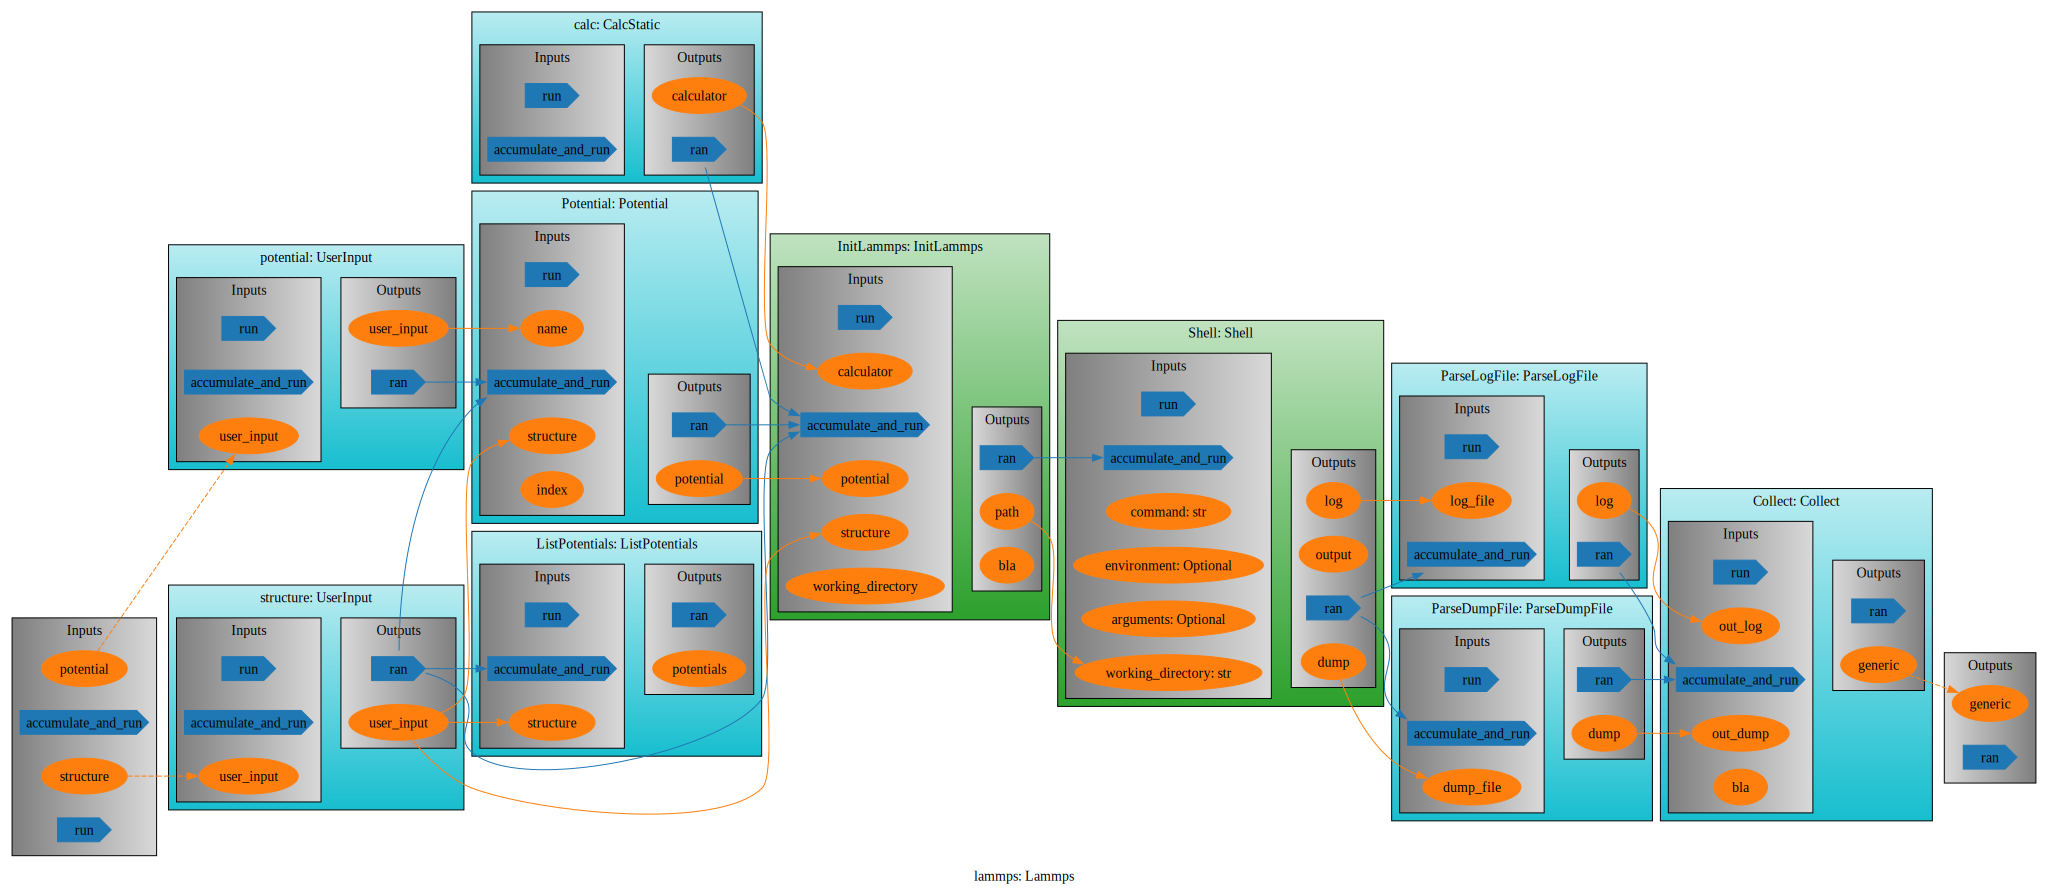

In [9]:
wf.lammps.draw(depth=2)

In [8]:
out = wf.run()
print (f'Potential energy: {wf.lammps.outputs.generic.value.energy_pot}')

Lammps_init:  static bla


NameError: name 'calc_mode' is not defined

In [ ]:
# wf.lammps.InitLammps.outputs.calculator.value

In [ ]:
wf.lammps.Collect.inputs.calculator = 

In [ ]:
wf.lammps.Collect.inputs.calculator.value = wf.lammps.InitLammps.outputs.calculator.value

In [ ]:
wf.lammps.Collect.run()

In [ ]:
wf.draw(depth=2)

### MD over list of temperatures

In [ ]:
%%time
for T in [300, 600, 900]:
    wf = Workflow('Lammps')
    wf.structure = wf.create.atomistic.structure.build.bulk('Al', cubic=True)
    wf.repeat = wf.create.atomistic.structure.transform.repeat(structure = wf.structure, repeat_scalar=3)
    
    wf.lammps = wf.create.atomistic_codes.Lammps(structure=wf.repeat, label='lammps')
    wf.lammps.calc_select.md(temperature=T, n_ionic_steps=10_000)
    print ('T=', wf.lammps.calc.inputs.temperature)
    
    wf.run()
    
    plt.plot(wf.lammps.outputs.generic.value.energy_pot[2:], label=f'T={T}K')
plt.legend();    

In [ ]:
wf.draw(depth=2);

In [ ]:
wf.lammps.draw();

### Murnaghan (E-V) macro

In [ ]:
@Workflow.wrap_as.macro_node('energy_pot')
def energy_at_volume(wf, element='Al', cell_size=2, strain=0):
    wf.bulk = wf.create.atomistic.build.cubic_bulk_cell(element=element, cubic=True, cell_size=cell_size)
    wf.apply_strain = wf.create.atomistic.structure.transform.apply_strain(structure=wf.bulk.outputs.structure, strain=strain)
    
    wf.lammps = wf.create.atomistic_codes.Lammps(structure=wf.apply_strain, label='lammps')
    
    return wf.lammps.outputs.generic.energy_pot

In [ ]:
df = energy_at_volume().iter(strain=np.linspace(-0.2, 0.2, 11))
df.plot(x='strain', ylabel='Energy (eV)', title='Energy-Volume Curve');

In [ ]:
import numpy as np

energy_pot = []
strain_lst = np.linspace(0.86, 1, 11) - 1
for strain in strain_lst:
    wf = energy_at_volume(element='Al', strain=strain)
    out = wf.run()

    energy_pot.append(out['energy_pot'])  

plt.plot(strain_lst, energy_pot);

### Data store

In [ ]:
from pyiron_workflow.node_library.dev_tools import DataStore, node_to_data_container, extract_value

In [ ]:
ds = DataStore(path='DataStore')
ds.store(wf, overwrite=True)

In [ ]:
wf_new = ds.load(wf.label)

In [ ]:
wf.lammps

In [ ]:
wf.outputs.energy_pot.value

TODO: Convert data_container to node

In [ ]:
out = wf(element='Fe')

In [ ]:
ds.remove(wf.label)

#### Test pickle

In [ ]:
import  cloudpickle as pickle

In [ ]:
with open('node.pickle', 'wb') as f:
    pickle.dump(wf, f)

In [ ]:
with open('node.pickle', 'rb') as f:
    new_node = pickle.load(f)

In [ ]:
new_node.run();

In [ ]:
new_node.outputs.energy_pot.value

In [ ]:
out.energy_pot

In [ ]:
out

## Apply Jan's atomistic class

In [ ]:
wf.create.atomistics

In [ ]:
wf = Workflow('Murnaghan')
wf.bulk = wf.create.atomistics.task.Bulk('Al', cubic=True)
wf.lammps = wf.create.atomistics.calculator.Lammps()
wf.lammps_potential = wf.create.atomistics.calculator.LammpsPotential(structure=wf.bulk)
wf.macro = wf.create.atomistics.macro.EnergyVolumeCurve(calculator=wf.lammps)

In [ ]:
bulk = wf.bulk.run()
bulk

In [ ]:
wf.lammps_potential.inputs

In [ ]:
wf.draw()

#### Debug example

In [10]:
@Workflow.wrap_as.single_value_node('string')
def create_string(my_string: str=''):
    return my_string

@Workflow.wrap_as.single_value_node('string')
def plus(my_string_1: str='', my_string_2: str='', my_string_3: str='', my_string_4: str=''):
    return my_string_1 + my_string_2 + my_string_3 + my_string_4

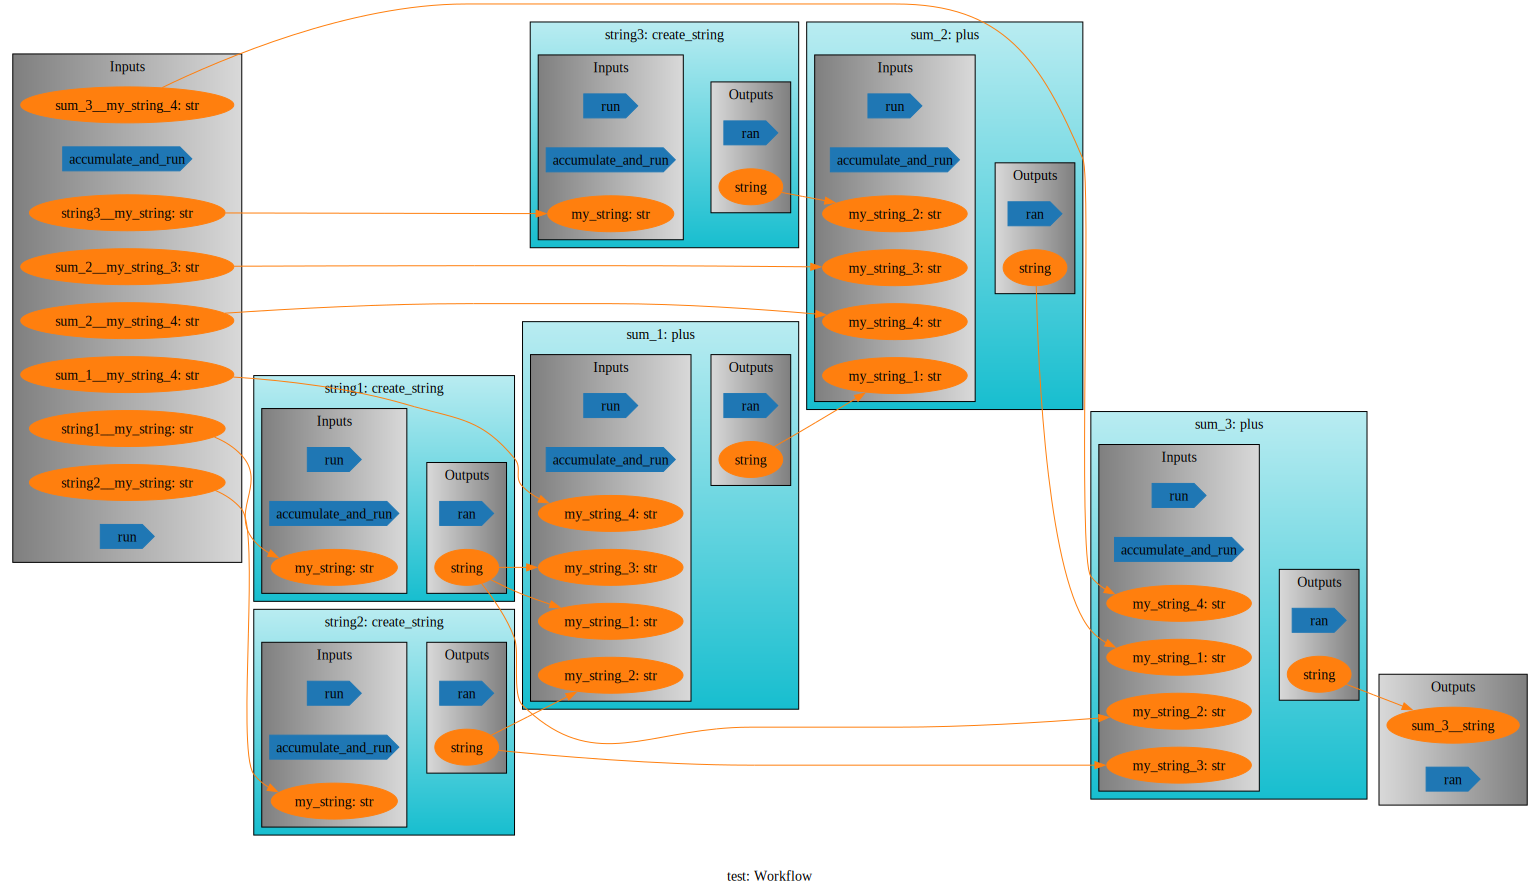

In [12]:
wf = Workflow('test')

wf.string1 = create_string('a')
wf.string2 = create_string('b')
wf.string3 = create_string('c')

wf.sum_1 = plus(wf.string1, wf.string2, wf.string1)
wf.sum_2 = plus(wf.sum_1, wf.string3)
wf.sum_3 = plus(wf.sum_2, wf.string1, wf.string2)

wf.draw()